In [1]:
import pandas as pd
import numpy as np
from numpy import nan

In [2]:
members = pd.read_csv('members.csv')
songs = pd.read_csv('songs.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs_extra = pd.read_csv('song_extra_info.csv')
sample = pd.read_csv('sample_submission.csv')

Скопируем функции из первой части, чтобы убрать наны и разделить жанры

In [3]:
def nan(df):
  for col in df.columns:
    print(df[col].isna().sum()) 
nan(songs_extra)
songs_extra['isrc'] = songs_extra['isrc'].fillna('Unknown')
songs_extra['name'] = songs_extra['name'].fillna('Unknown')
songs_extra.head()

0
2
136548


,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [4]:
songs = pd.read_csv('songs.csv')
songs['genre_ids'] = songs['genre_ids'].fillna(0)
songs['composer'] = songs['composer'].fillna('Unknown')
songs['lyricist'] = songs['lyricist'].fillna('Unknown')
songs['language'] = songs['language'].fillna(0)
def genre_dev(genre, ind):
    splitted = str(genre).split('|')
    if (len(splitted) <= ind):
        return 'na'
    else:
        return splitted[ind]
songs['g1'] = songs['genre_ids'].map(lambda g: genre_dev(g, 0))
songs['g2'] = songs['genre_ids'].map(lambda g: genre_dev(g, 1))
songs['g3'] = songs['genre_ids'].map(lambda g: genre_dev(g, 2))
songs = songs.drop(['genre_ids'], axis=1)

Объединим данные, не забывая, что для word2vec нужно использовать только строчки с target = 1

In [5]:
train.head()
merged_train = train.merge(songs, on='song_id').merge(songs_extra, on='song_id')
merged_train = merged_train[merged_train['target'] == 1]

Выберем только популярные песни

In [6]:
from collections import defaultdict
s = defaultdict(int)
def add(song):
    s[song] += 1
merged_train['song_id'].map(lambda song : add(song))
ans = set()
for x in s:
    if (s[x] > 20) :
        ans.add(x)

In [7]:
merged_train2 = merged_train.loc[merged_train.song_id.isin(ans)]
merged_train4 = train.merge(songs, on='song_id').merge(songs_extra, on='song_id')
merged_train4 = merged_train4.loc[merged_train4.song_id.isin(ans)]

Наконец, необходимо сгруппировать песни для каждого пользователя, чтобы передать их Word2vec https://habr.com/ru/post/446530/

In [8]:
word_to_vec = []
grouped = merged_train2.groupby('msno')
for elem in grouped.groups:
    one_vec = grouped.get_group(elem)
    #print(one_vec['song_id'].values)
    arr = []
    for el in one_vec['song_id'].values:
        arr.append(el)
    word_to_vec.append(arr)

In [9]:
from gensim.models import Word2Vec
model = Word2Vec(min_count=1)
model.build_vocab(word_to_vec)
model.train(word_to_vec, total_examples=model.corpus_count, epochs=100)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


(309626505, 310377200)

После получения данных о песнях получим данные пользователя (сложим понравившиеся песни, чтобы получить его представление Word2Vec). Затем вернемся к изначальной таблички, чтобы добавить столбик, получающийся как скалярное произведение векторов человека на песню.

In [10]:
word_to_vec_dict = dict()
grouped = merged_train2.groupby('msno')
for elem in grouped.groups:
    one_vec = grouped.get_group(elem)
    #print(one_vec['song_id'].values)
    ans = np.zeros(100)
    amount = 0
    for el in one_vec['song_id'].values:
        ans += model.wv[el]
        amount += 1
    word_to_vec_dict[elem] = ans / amount
word_to_vec_dict

{'++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=': array([ 5.11803181e-01, -4.02916350e-01,  9.88723418e-02,  4.29482614e-02,
         1.12566301e-02,  3.76609728e-03,  5.06187854e-01,  1.68623560e-01,
        -1.43003838e-01, -1.39754201e-01, -3.76500423e-02,  3.11287525e-01,
         9.50900731e-02, -1.32248122e-01,  1.72550782e-03,  8.34757387e-02,
        -7.31653780e-02,  3.74278890e-01,  3.56699675e-04,  4.37572927e-01,
        -2.36156869e-01,  8.58556105e-02, -3.31796914e-02,  4.00449689e-01,
        -2.45072995e-02,  1.53005400e-02,  1.68306729e-01, -1.37149461e-01,
         8.16827293e-02, -1.28577790e-01, -3.90886255e-02,  1.92354996e-01,
         2.31053050e-01,  5.02558313e-02, -1.46831018e-01,  2.68358837e-01,
        -3.24261946e-02,  4.59663153e-01, -2.93567104e-01, -2.64571034e-01,
        -1.85780132e-01, -2.05051947e-01, -2.22443610e-01, -5.88178309e-02,
        -2.27621272e-01, -3.43943769e-01, -1.70851844e-01, -2.68412728e-02,
        -7.52904533e-02, -2.69865295e-01

In [11]:
cosine_dict = dict()
merged_train3 = merged_train4.copy()
def make_word2vec(x):
    try:
        return np.cosine_similarity(word_to_vec_dict[x.msno], model.wv[x.song_id])
    except:
        return -1
merged_train3['word2vec'] = merged_train3.apply(lambda x : make_word2vec(x), axis=1)

In [12]:
merged_train3

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,artist_name,composer,lyricist,language,g1,g2,g3,name,isrc,word2vec
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,Bastille,Dan Smith| Mark Crew,Unknown,52.0,359,na,na,Good Grief,GBUM71602854,-1
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-playlist,1,206471,Bastille,Dan Smith| Mark Crew,Unknown,52.0,359,na,na,Good Grief,GBUM71602854,-1
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,Bastille,Dan Smith| Mark Crew,Unknown,52.0,359,na,na,Good Grief,GBUM71602854,-1
3,sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,Bastille,Dan Smith| Mark Crew,Unknown,52.0,359,na,na,Good Grief,GBUM71602854,-1
4,hKdGiUKHVqKkXGHLrc+EzdSW6q0ERAJ2Cs7/L1N0Ae4=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,NaN,online-playlist,0,206471,Bastille,Dan Smith| Mark Crew,Unknown,52.0,359,na,na,Good Grief,GBUM71602854,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365086,GiwOY8l/lt/hovRLP3bbB/J1JSDUUvA6MwTbYTfnl9U=,XXATx1PMAfjmWUqCb8rYCWrVvo3QEdjILY7XcqJw9zM=,my library,Local playlist more,local-library,1,214177,Gallant x Tablo x Eric Nam,Unknown,Unknown,52.0,139,na,na,Cave Me In,USWB11602567,-1
7365087,JyxQaIHWJdHAi5+FSAoetgsHZ72jpdLtuSWNa8RJWOo=,XXATx1PMAfjmWUqCb8rYCWrVvo3QEdjILY7XcqJw9zM=,discover,Online playlist more,online-playlist,1,214177,Gallant x Tablo x Eric Nam,Unknown,Unknown,52.0,139,na,na,Cave Me In,USWB11602567,-1
7365088,LDAkeSKc+BjZvmkdCSBcA0mW16D/AlaA3OQijsybtYk=,XXATx1PMAfjmWUqCb8rYCWrVvo3QEdjILY7XcqJw9zM=,discover,Discover Feature,online-playlist,0,214177,Gallant x Tablo x Eric Nam,Unknown,Unknown,52.0,139,na,na,Cave Me In,USWB11602567,-1
7365089,sOOABBEHWMUhHFP15eAKkLnf6tYNRzi4iuFv1kgrDig=,XXATx1PMAfjmWUqCb8rYCWrVvo3QEdjILY7XcqJw9zM=,discover,Online playlist more,online-playlist,1,214177,Gallant x Tablo x Eric Nam,Unknown,Unknown,52.0,139,na,na,Cave Me In,USWB11602567,-1


Далее два раза используем катбуст (сначала используя все фичи, а затем только имя песни, человека и word2vec)

In [13]:
merged_train6 = merged_train3[['msno', 'song_id', 'word2vec', 'target']]

In [14]:
merged_train5 = merged_train3.reset_index(drop=True)
merged_train5['source_system_tab'] = merged_train5['source_system_tab'].fillna('Unknown')
merged_train5['source_screen_name'] = merged_train5['source_screen_name'].fillna('Unknown')
merged_train5['source_type'] = merged_train5['source_type'].fillna('Unknown')
merged_train5['language'] = merged_train5['language'].map(lambda x : str(x))
Y1 = merged_train5['target']
X1 = merged_train5.drop(['target'], axis=1)

Периодически ловил проблему CatBoostError: bad allocation, так и не понял как ее решить, приходилось обучать несколько дней, чтобы добиться результата

In [15]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score, cross_validate

paramparam = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'artist_name', 'composer', 'lyricist', 'language', 'g1', 'g2', 'g3', 'name', 'isrc']

cv_dataset = Pool(data=X1,
                  label=Y1,
                  cat_features = paramparam)

model1 = CatBoostRegressor(task_type='CPU', loss_function='RMSE', iterations=100)
model1.fit(cv_dataset)
#model = CatBoostClassifier(iterations=1000, learning_rate=1e-5, depth=4, cat_features = ["msno", "song_id", "source_system_tab", "source_screen_name", "source_type", "gender"])
#model.fit(X, Y)

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False,
          "custom_metric": 'AUC'}


scores1 = cv(cv_dataset,
            params,
            fold_count=4,
            shuffle=True, 
            plot=True)

scores1

Learning rate set to 0.5
0:	learn: 0.4857149	total: 11.2s	remaining: 18m 28s
1:	learn: 0.4672326	total: 16.6s	remaining: 13m 35s
2:	learn: 0.4595856	total: 21.2s	remaining: 11m 26s
3:	learn: 0.4547186	total: 25.4s	remaining: 10m 9s
4:	learn: 0.4529398	total: 29.9s	remaining: 9m 28s
5:	learn: 0.4520074	total: 33.9s	remaining: 8m 51s
6:	learn: 0.4509189	total: 37.6s	remaining: 8m 20s
7:	learn: 0.4503515	total: 41.5s	remaining: 7m 57s
8:	learn: 0.4499380	total: 45.3s	remaining: 7m 38s
9:	learn: 0.4496517	total: 49s	remaining: 7m 21s
10:	learn: 0.4494215	total: 52.7s	remaining: 7m 6s
11:	learn: 0.4492488	total: 56.5s	remaining: 6m 54s
12:	learn: 0.4491186	total: 1m	remaining: 6m 44s
13:	learn: 0.4490230	total: 1m 4s	remaining: 6m 34s
14:	learn: 0.4489195	total: 1m 7s	remaining: 6m 25s
15:	learn: 0.4488156	total: 1m 11s	remaining: 6m 16s
16:	learn: 0.4487102	total: 1m 15s	remaining: 6m 7s
17:	learn: 0.4486378	total: 1m 19s	remaining: 5m 59s
18:	learn: 0.4485720	total: 1m 22s	remaining: 5m 5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-AUC-mean,test-AUC-std
0,0,0.720005,0.000195,0.720004,0.000061,0.630414,0.003342
1,1,0.708196,0.000192,0.708192,0.000057,0.633615,0.001885
2,2,0.696890,0.000189,0.696884,0.000054,0.633890,0.001599
3,3,0.686081,0.000187,0.686075,0.000050,0.634300,0.001857
4,4,0.675762,0.000182,0.675748,0.000047,0.635028,0.000853
...,...,...,...,...,...,...,...
95,95,0.462771,0.000110,0.464200,0.000090,0.722660,0.000564
96,96,0.462432,0.000114,0.463874,0.000086,0.723451,0.000532
97,97,0.462105,0.000114,0.463560,0.000083,0.724156,0.000555
98,98,0.461797,0.000113,0.463262,0.000080,0.724750,0.000545


In [16]:
Y2 = merged_train6['target']
X2 = merged_train6.drop(['target'], axis=1)

from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score, cross_validate

paramparam = ['msno', 'song_id']

cv_dataset = Pool(data=X2,
                  label=Y2,
                  cat_features = paramparam)

model2 = CatBoostRegressor(task_type='CPU', loss_function='RMSE', iterations=100)
model2.fit(cv_dataset)
#model = CatBoostClassifier(iterations=1000, learning_rate=1e-5, depth=4, cat_features = ["msno", "song_id", "source_system_tab", "source_screen_name", "source_type", "gender"])
#model.fit(X, Y)

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False,
          "custom_metric": 'AUC'}


scores2 = cv(cv_dataset,
            params,
            fold_count=4,
            shuffle=True, 
            plot=True)

scores2

Learning rate set to 0.5
0:	learn: 0.4763134	total: 1.3s	remaining: 2m 8s
1:	learn: 0.4697547	total: 2.37s	remaining: 1m 56s
2:	learn: 0.4632264	total: 3.61s	remaining: 1m 56s
3:	learn: 0.4611359	total: 4.58s	remaining: 1m 50s
4:	learn: 0.4599137	total: 5.58s	remaining: 1m 45s
5:	learn: 0.4593922	total: 6.6s	remaining: 1m 43s
6:	learn: 0.4586310	total: 7.54s	remaining: 1m 40s
7:	learn: 0.4583150	total: 8.45s	remaining: 1m 37s
8:	learn: 0.4581478	total: 9.37s	remaining: 1m 34s
9:	learn: 0.4580278	total: 10.3s	remaining: 1m 32s
10:	learn: 0.4579709	total: 11.2s	remaining: 1m 30s
11:	learn: 0.4579122	total: 12.1s	remaining: 1m 28s
12:	learn: 0.4578683	total: 13s	remaining: 1m 27s
13:	learn: 0.4578323	total: 14s	remaining: 1m 25s
14:	learn: 0.4578039	total: 14.9s	remaining: 1m 24s
15:	learn: 0.4577837	total: 15.8s	remaining: 1m 23s
16:	learn: 0.4577535	total: 16.8s	remaining: 1m 22s
17:	learn: 0.4577306	total: 17.7s	remaining: 1m 20s
18:	learn: 0.4577174	total: 18.7s	remaining: 1m 19s
19:	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-AUC-mean,test-AUC-std
0,0,0.720481,0.000200,0.720409,0.000062,0.588955,0.001880
1,1,0.709094,0.000213,0.708979,0.000058,0.595338,0.004740
2,2,0.698116,0.000212,0.698052,0.000055,0.600950,0.001106
3,3,0.687628,0.000195,0.687612,0.000061,0.602075,0.001144
4,4,0.677650,0.000171,0.677642,0.000058,0.602241,0.001100
...,...,...,...,...,...,...,...
95,95,0.463917,0.000128,0.466700,0.000047,0.725743,0.000538
96,96,0.463706,0.000134,0.466509,0.000045,0.725838,0.000480
97,97,0.463504,0.000133,0.466329,0.000048,0.725984,0.000493
98,98,0.463309,0.000132,0.466154,0.000047,0.726086,0.000535


In [18]:
import shap

explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(X1)
explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer2.shap_values(X2)

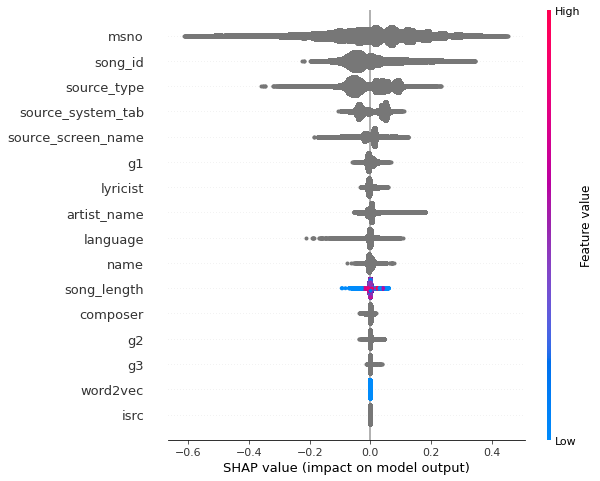

In [19]:
shap.summary_plot(shap_values1, X1)

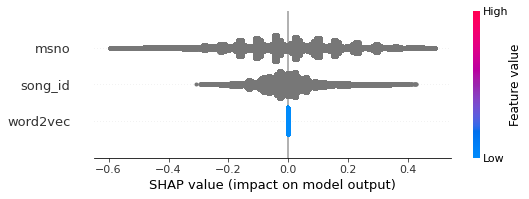

In [20]:
shap.summary_plot(shap_values2, X2)

In [ ]:
shap.dependence_plot("msno", shap_values1, X1)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


In [ ]:
shap.dependence_plot("msno", shap_values2, X2)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values1, X1)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values2, X2)